In [1]:
!pip install --quiet -r requirements.txt

In [2]:
!nvidia-smi

Sun Jan  1 14:04:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1F:00.0  On |                  N/A |
| 83%   62C    P5    29W / 170W |    958MiB / 12288MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os

filenames = []
for root, dirs, files in os.walk("CCPD2019-dl1"):
    for f in files:
        if f.endswith(".jpg") or f.endswith(".JPG"):
            filenames.append(os.path.join(root, f))
filenames[:5]

['CCPD2019-dl1/test/0319-皖ASW872.jpg',
 'CCPD2019-dl1/test/0401-皖AWW227.jpg',
 'CCPD2019-dl1/test/0199-皖AX0L55.jpg',
 'CCPD2019-dl1/test/0245-皖A9U395.jpg',
 'CCPD2019-dl1/test/0389-皖AT219T.jpg']

In [4]:
len(filenames)

209979

In [5]:
def get_label(filename: str) -> str:
    return filename.split(".")[0].split("-")[-1]

filenames[0], get_label(filenames[0])

('CCPD2019-dl1/test/0319-皖ASW872.jpg', '皖ASW872')

In [6]:
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def plot(index: int):
    plt.imshow(cv2.cvtColor(cv2.imread(filenames[index]), cv2.COLOR_BGR2RGB));
    plt.axis("off")
    plt.show()

interact(plot, index=IntSlider(min=0, max=len(filenames) - 1, value=0));

interactive(children=(IntSlider(value=0, description='index', max=209978), Output()), _dom_classes=('widget-in…

In [7]:
labels = list(map(get_label, filenames))
all_w, all_h, ratio = [], [], []

for filename in filenames[:20000]:
    h, w, _ = cv2.imread(filename).shape
    all_w.append(w)
    all_h.append(h)
    ratio.append(w / h)

In [8]:
import numpy as np

lens = list(map(len, labels))
np.mean(all_w), np.mean(all_h), np.mean(ratio), np.mean(lens)

(254.9241, 86.28205, 2.9521506126516366, 7.0)

In [9]:
from collections import Counter

print(Counter(all_w).most_common(5), Counter(all_h).most_common(5), Counter(ratio).most_common(5), Counter(lens).most_common(5), sep="\n")

[(244, 151), (225, 150), (235, 148), (231, 147), (220, 146)]
[(80, 504), (78, 494), (84, 492), (82, 492), (86, 491)]
[(3.0, 366), (2.75, 59), (2.8, 53), (2.6666666666666665, 53), (2.857142857142857, 51)]
[(7, 209979)]


# Augmentations

In [10]:
import albumentations as A

img_w, img_h = 256, 96

transforms = A.Compose([
    A.Resize(img_h, img_w, interpolation=cv2.INTER_CUBIC),
    A.Rotate(limit=10, p=0.25),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5)
])

val_transforms = A.Compose([
    A.Resize(img_h, img_w, interpolation=cv2.INTER_CUBIC),
])

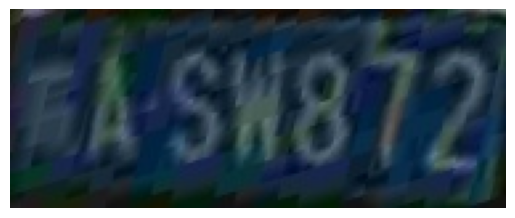

In [11]:
img = cv2.cvtColor(cv2.imread(filenames[0]), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off");

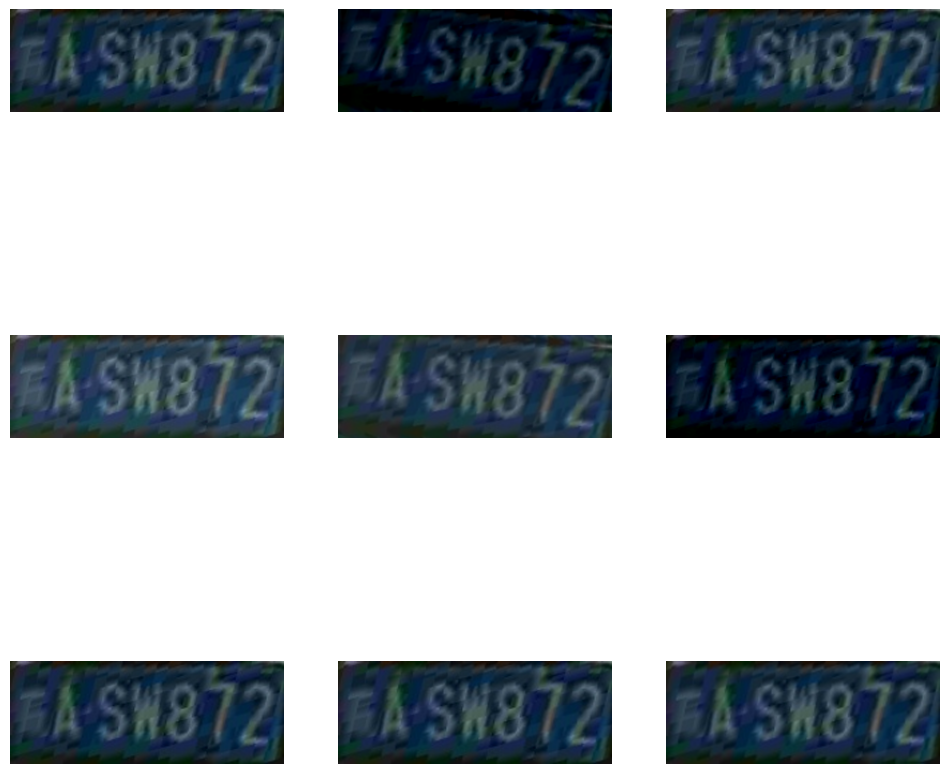

In [12]:
nrows, ncols = 3, 3
_, axs = plt.subplots(nrows, ncols, figsize=(12, 12))

for i in range(nrows):
    for j in range(ncols):
        transformed = transforms(image=img)["image"]
        axs[i][j].imshow(transformed)
        axs[i][j].axis("off")

# Tokenizer

In [13]:
import numpy as np

alphabet = np.array(sorted(list(set("".join(labels)))))
alphabet

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q',
       'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '云', '京', '冀', '吉',
       '宁', '川', '新', '晋', '桂', '沪', '津', '浙', '渝', '湘', '琼', '甘', '皖',
       '粤', '苏', '蒙', '藏', '豫', '贵', '赣', '辽', '鄂', '闽', '陕', '青', '鲁',
       '黑'], dtype='<U1')

In [14]:
alphabet.shape

(66,)

In [15]:
!python --version

Python 3.10.8


In [16]:
#from __future__ import annotations

class Tokenizer:
    def __init__(self, alphabet: list[str]):
        self.word2token = {alphabet[i]: i for i in range(len(alphabet))}
        self.token2word = {v: k for k, v in self.word2token.items()}

    def encode(self, x: str) -> list[int]:
        return [self.word2token[i] for i in x]

    def __call__(self, x: str) -> list[int]:
        return self.encode(x)

    def decode(self, tokens: list[int]) -> str:
        return "".join([self.token2word[i] for i in tokens])

    def __len__(self) -> int:
        return len(self.word2token)

tokenizer = Tokenizer(alphabet)
len(tokenizer)

66

In [17]:
tokenized = tokenizer(labels[0])
labels[0], tokenized, tokenizer.decode(tokenized) 

('皖ASW872', [51, 10, 27, 31, 8, 7, 2], '皖ASW872')

# Dataset

In [18]:
x_train = list(filter(lambda x: "train" in x, filenames))
x_test = list(filter(lambda x: "test" in x, filenames))
x_train[0], x_test[0]

('CCPD2019-dl1/train/0244025383142-皖APX882.jpg',
 'CCPD2019-dl1/test/0319-皖ASW872.jpg')

In [19]:
len(x_train), len(x_test)

(199980, 9999)

In [20]:
y_train = list(map(get_label, x_train))
y_test = list(map(get_label, x_test))
y_train[0], y_test[0]

('皖APX882', '皖ASW872')

In [21]:
len(y_train), len(y_test)

(199980, 9999)

In [22]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(3407)
torch.cuda.manual_seed_all(3407)
device

device(type='cuda', index=0)

In [23]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class OCRDataset(Dataset):
    def __init__(self, filenames: list[str], labels: list[str], transforms=None):
        self.filenames, self.labels, self.transforms = filenames, labels, transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index: int):
        img = cv2.cvtColor(cv2.imread(self.filenames[index]), cv2.COLOR_BGR2RGB)
        if self.transforms:
            img = transforms(image=img)["image"]
        img = ToTensor()(img)
        return img, torch.LongTensor(tokenizer(self.labels[index]))

train_ds = OCRDataset(x_train, y_train, transforms)
val_ds = OCRDataset(x_test, y_test, val_transforms)

batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

train_ds[0]

(tensor([[[0.0549, 0.0549, 0.0549,  ..., 0.6196, 0.0549, 0.0745],
          [0.0549, 0.0549, 0.0549,  ..., 0.6706, 0.0549, 0.0667],
          [0.0588, 0.0549, 0.0549,  ..., 0.6706, 0.0549, 0.0627],
          ...,
          [0.1608, 0.1608, 0.1608,  ..., 0.0549, 0.0549, 0.0549],
          [0.1765, 0.1804, 0.1765,  ..., 0.0549, 0.0549, 0.0549],
          [0.1804, 0.1961, 0.2000,  ..., 0.0549, 0.0549, 0.0549]],
 
         [[0.0627, 0.0588, 0.0588,  ..., 0.6039, 0.0549, 0.0588],
          [0.0549, 0.0588, 0.0627,  ..., 0.6667, 0.0549, 0.0549],
          [0.0549, 0.0549, 0.0549,  ..., 0.6706, 0.0549, 0.0549],
          ...,
          [0.1686, 0.1647, 0.1608,  ..., 0.0549, 0.0549, 0.0549],
          [0.1765, 0.1804, 0.1765,  ..., 0.0549, 0.0549, 0.0549],
          [0.1804, 0.1961, 0.2000,  ..., 0.0549, 0.0549, 0.0549]],
 
         [[0.0549, 0.0549, 0.0627,  ..., 0.6000, 0.0549, 0.0549],
          [0.0549, 0.0549, 0.0588,  ..., 0.6588, 0.0549, 0.0549],
          [0.0549, 0.0549, 0.0549,  ...,

In [24]:
train_ds[0][0].size(), train_ds[0][1].size()

(torch.Size([3, 96, 256]), torch.Size([7]))

# CRNN

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.activate_fn = nn.ReLU(inplace=True) 
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.activate_fn(x)
        x = self.bn(x)
        return x

class RNNBlock(nn.Module):    
    def __init__(self, input_size: int, hidden_size: int, num_layers=2, dropout=0.1, bidirectional=True):
        super().__init__()    
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)

    def forward(self, x):
        out, _ = self.rnn(x)
        return out

In [26]:
class CRNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.cnn = nn.Sequential(
            ConvBlock(3, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d(kernel_size=2),

            ConvBlock(64, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d(kernel_size=2),

            ConvBlock(128, 256),
            ConvBlock(256, 256),
            nn.MaxPool2d(kernel_size=2)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((7, 256))

        self.rnn = RNNBlock(256, 128)

        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        bs, ch, h, w = x.size()
        x = x.reshape(bs, -1, 256)
        x = self.avg_pool(x)
        x = self.rnn(x)
        x = self.classifier(x)
        x = x.transpose(2, 1)
        return x

model = CRNN(len(tokenizer))
model = model.to(device)
model

CRNN(
  (cnn): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate_fn): ReLU(inplace=True)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate_fn): ReLU(inplace=True)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate_fn): ReLU(inplace=True)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate_fn): ReLU(inplace=True)
      (bn): BatchNorm2d(128, eps

In [27]:
from torchsummary import summary

summary(model, (3, 96, 256));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 12, 32]         --
|    └─ConvBlock: 2-1                    [-1, 64, 96, 256]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 96, 256]         1,792
|    |    └─ReLU: 3-2                    [-1, 64, 96, 256]         --
|    |    └─BatchNorm2d: 3-3             [-1, 64, 96, 256]         128
|    └─ConvBlock: 2-2                    [-1, 64, 96, 256]         --
|    |    └─Conv2d: 3-4                  [-1, 64, 96, 256]         36,928
|    |    └─ReLU: 3-5                    [-1, 64, 96, 256]         --
|    |    └─BatchNorm2d: 3-6             [-1, 64, 96, 256]         128
|    └─MaxPool2d: 2-3                    [-1, 64, 48, 128]         --
|    └─ConvBlock: 2-4                    [-1, 128, 48, 128]        --
|    |    └─Conv2d: 3-7                  [-1, 128, 48, 128]        73,856
|    |    └─ReLU: 3-8                    [-1, 128, 48, 128]        --
| 

# Utils

In [28]:
from Levenshtein import distance

def CER(pred: list[str], true: list[str]) -> float:
    return np.mean([distance(p, t) / max(len(p), len(t)) for p, t in zip(pred, true)])

def accuracy(pred: list[str], true: list[str]) -> float:
    return np.mean([p == t for p, t in zip(pred, true)])

CER(["皖APX882"], ["皖APX8782"]), CER(["皖APX882"], ["皖APX8772"]), accuracy(["皖APX882", "皖APX883", "皖APX884", "皖APX885"], ["皖APX882", "皖APX882", "皖APX884", "皖APX882"])

(0.125, 0.25, 0.5)

In [29]:
def prob2word(p: list[list[float]]) -> str:
    return tokenizer.decode([np.argmax(i) for i in p])

prob2word([[0.1, 0.6, 0.3, 0], [0.5, 0.4, 0.1, 0], [0, 0, 0, 1]]), list(tokenizer.token2word.items())[:5]

('103', [(0, '0'), (1, '1'), (2, '2'), (3, '3'), (4, '4')])

In [30]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Training

In [31]:
from tqdm.notebook import tqdm

def training(model, dl, criterion, optimizer, scheduler=None):
    model.train()
    loss_meter, acc_meter, cer_meter = AverageMeter(), AverageMeter(), AverageMeter()
    for x, y in tqdm(dl):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        out = model(x)

        loss = criterion(out, y)
        
        pred = list(map(prob2word, out.transpose(2, 1).cpu().detach().numpy()))
        true = list(map(tokenizer.decode, y.cpu().detach().numpy()))
        
        loss_meter.update(loss.item())
        acc_meter.update(accuracy(pred, true))
        cer_meter.update(CER(pred, true))
        
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        del x
        del y
        del out
        del loss
        del pred
        del true
        torch.cuda.empty_cache()
    return loss_meter.avg, acc_meter.avg, cer_meter.avg

def validation(model, dl, criterion):
    model.eval()
    loss_meter, acc_meter, cer_meter = AverageMeter(), AverageMeter(), AverageMeter()
    for x, y in dl:
        x, y = x.to(device), y.to(device)

        with torch.no_grad():
            out = model(x)

        loss = criterion(out, y)

        pred = list(map(prob2word, out.transpose(2, 1).cpu().detach().numpy()))
        true = list(map(tokenizer.decode, y.cpu().detach().numpy()))
        
        loss_meter.update(loss.item())
        acc_meter.update(accuracy(pred, true))
        cer_meter.update(CER(pred, true))        

        del x
        del y
        del out
        del loss
        del pred
        del true
        torch.cuda.empty_cache()
    return loss_meter.avg, acc_meter.avg, cer_meter.avg

In [32]:
import shutil
import gc

try:
    shutil.rmtree("checkpoints")
except FileNotFoundError:
    pass
finally:
    os.makedirs("checkpoints", exist_ok=True)

epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

best_val_loss = float("inf")

all_train_loss, all_train_acc, all_train_cer = [], [], []
all_val_loss, all_val_acc, all_val_cer = [], [], []

for e in range(1, epochs + 1): 
    print(f"========== Epoch {e} / {epochs} ==========")

    train_loss, train_acc, train_cer = training(model, train_dl, criterion, optimizer)
    print(f"Train loss {train_loss} accuracy {train_acc} CER {train_cer}")
    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)
    all_train_cer.append(train_cer)
    
    val_loss, val_acc, val_cer = validation(model, val_dl, criterion)
    print(f"Validation loss {val_loss} accuracy {val_acc} CER {val_cer}\n")
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)
    all_val_cer.append(val_cer)
     
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"checkpoints/epoch={e};loss={val_loss}")
    
    gc.collect()

========== Epoch 1 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.45709893480896646 accuracy 0.6876967552201478 CER 0.12333663617252884
Validation loss 0.08500499303063637 accuracy 0.8981408227848101 CER 0.02013166817359855

========== Epoch 2 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.026273303878983998 accuracy 0.9581293077124411 CER 0.006739661490141335
Validation loss 0.058788502706757076 accuracy 0.924940664556962 CER 0.014508928571428567

========== Epoch 3 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.016522144474746373 accuracy 0.971769033909149 CER 0.004424298510191025
Validation loss 0.0422614835190905 accuracy 0.9452136075949367 CER 0.01028481012658228

========== Epoch 4 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.011459875265659225 accuracy 0.9794670250974233 CER 0.0031774247825111703
Validation loss 0.04620456840560029 accuracy 0.9395239978902954 CER 0.011267141350210974

========== Epoch 5 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.009397910206523705 accuracy 0.9829559086546851 CER 0.0026633685013003764
Validation loss 0.045520578704102414 accuracy 0.9392800632911392 CER 0.011556283905967453

========== Epoch 6 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.007390949275164066 accuracy 0.986434795410923 CER 0.002113544444998388
Validation loss 0.040412505729053215 accuracy 0.9461036392405063 CER 0.01024242766726944

========== Epoch 7 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.005837200362419204 accuracy 0.9889489908683767 CER 0.0016908225731402328
Validation loss 0.03287486243356444 accuracy 0.9550039556962026 CER 0.008236324593128393

========== Epoch 8 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.005147156110961811 accuracy 0.9905130358285349 CER 0.0014752422082076556
Validation loss 0.029045885817819757 accuracy 0.9597507911392406 CER 0.00728978300180832

========== Epoch 9 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.004675342475732351 accuracy 0.9911778230966091 CER 0.0013781304268348335
Validation loss 0.029022535850932007 accuracy 0.9600474683544303 CER 0.00721914556962025

========== Epoch 10 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.003920244600211253 accuracy 0.992522392834293 CER 0.0011653413764738032
Validation loss 0.02880717850164245 accuracy 0.9607397151898734 CER 0.00720501808318264

========== Epoch 11 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.0036194277222167956 accuracy 0.9929627064793811 CER 0.0010845879967760863
Validation loss 0.023710776082110366 accuracy 0.9668710443037974 CER 0.006060691681735983

========== Epoch 12 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.003245913009259259 accuracy 0.9936870201535508 CER 0.0009725459281601239
Validation loss 0.036751869217127184 accuracy 0.9495648734177216 CER 0.009889240506329116

========== Epoch 13 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.002839836073081437 accuracy 0.9945721914441924 CER 0.0008396663716961179
Validation loss 0.025179882118289795 accuracy 0.9609375 CER 0.007021360759493665

========== Epoch 14 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.002806696706186022 accuracy 0.994476767434421 CER 0.0008468718581482436
Validation loss 0.026161488008359744 accuracy 0.9654865506329114 CER 0.006244349005424954

========== Epoch 15 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.0024493736921194784 accuracy 0.9953664827255279 CER 0.0007090588154647622
Validation loss 0.024989574671283814 accuracy 0.9648931962025317 CER 0.006258476491862565

========== Epoch 16 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.00251026870657116 accuracy 0.9949625210841622 CER 0.000762483278078284
Validation loss 0.0282824625116714 accuracy 0.9642009493670886 CER 0.0065268987341772135

========== Epoch 17 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.0021631120653590056 accuracy 0.995816338771593 CER 0.000637653093867105
Validation loss 0.02311562292448752 accuracy 0.9695411392405063 CER 0.005467337251356236

========== Epoch 18 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.002014831066763753 accuracy 0.9961462332053743 CER 0.0005840988026688597
Validation loss 0.025750953161829633 accuracy 0.9669699367088608 CER 0.006131329113924047

========== Epoch 19 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.00198260690326702 accuracy 0.9958713211772233 CER 0.000616231377387806
Validation loss 0.02216226708540351 accuracy 0.9716178797468354 CER 0.005142405063291135

========== Epoch 20 / 20 ==========


  0%|          | 0/1563 [00:00<?, ?it/s]

Train loss 0.0019587353731015285 accuracy 0.9961162428023033 CER 0.0005926674892605787
Validation loss 0.027547409252522963 accuracy 0.962618670886076 CER 0.006696428571428572



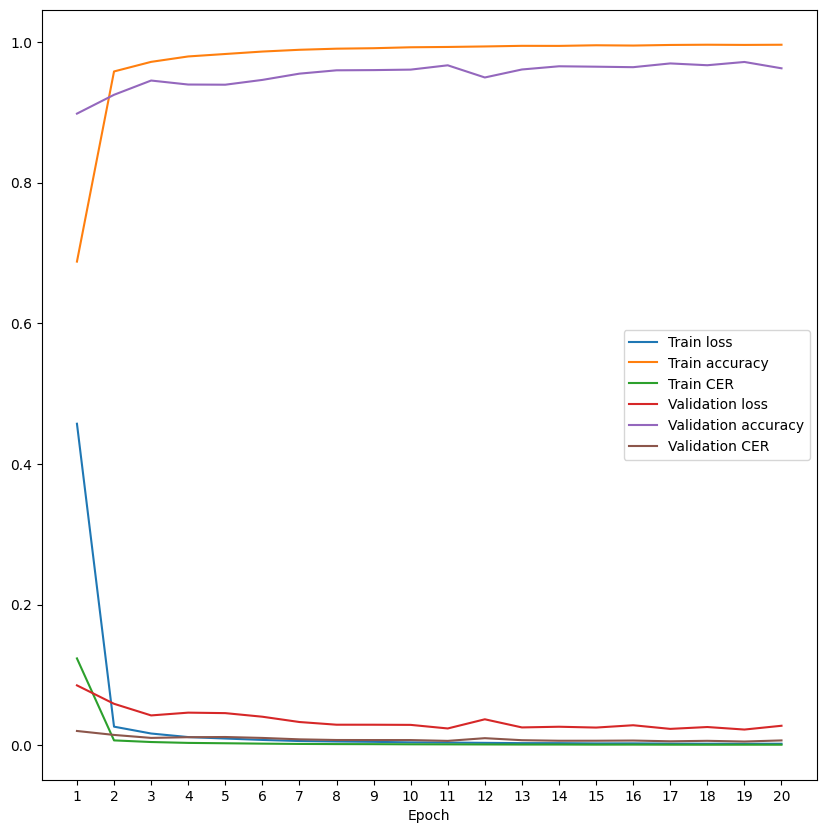

In [33]:
n = np.arange(1, epochs + 1)

plt.figure(figsize=(10, 10))
plt.plot(n, all_train_loss, label="Train loss")
plt.plot(n, all_train_acc, label="Train accuracy")
plt.plot(n, all_train_cer, label="Train CER")
plt.plot(n, all_val_loss, label="Validation loss")
plt.plot(n, all_val_acc, label="Validation accuracy")
plt.plot(n, all_val_cer, label="Validation CER")
plt.xlabel("Epoch")
plt.xticks(n)
plt.legend()
plt.show()

# Evaluate

In [34]:
models = sorted(os.listdir("checkpoints"), reverse=True)
models

['epoch=9;loss=0.029022535850932007',
 'epoch=8;loss=0.029045885817819757',
 'epoch=7;loss=0.03287486243356444',
 'epoch=6;loss=0.040412505729053215',
 'epoch=3;loss=0.0422614835190905',
 'epoch=2;loss=0.058788502706757076',
 'epoch=1;loss=0.08500499303063637',
 'epoch=19;loss=0.02216226708540351',
 'epoch=17;loss=0.02311562292448752',
 'epoch=11;loss=0.023710776082110366',
 'epoch=10;loss=0.02880717850164245']

In [35]:
from dataclasses import dataclass, field
from collections import defaultdict
from ipywidgets import Dropdown
import pandas as pd

@dataclass
class Info:
    filename: str = ""
    pred: str = ""
    true: str = ""
    metrics: list[float] = field(default_factory=list)

def evaluate(model_name):
    model = CRNN(len(tokenizer)).to(device)
    model.load_state_dict(torch.load(os.path.join("checkpoints", model_name)))
    model.eval()

    loss_meter, acc_meter, cer_meter = AverageMeter(), AverageMeter(), AverageMeter()
    max_cer, max_loss = np.zeros(10), np.zeros(10)
    max_cer_info, max_loss_info = [Info() for _ in range(10)], [Info() for _ in range(10)]
    for filename in tqdm(x_test):
        img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
        x = val_transforms(image=img)["image"]
        x = torch.unsqueeze(ToTensor()(x), 0).to(device)
        label = get_label(filename)
        y = torch.unsqueeze(torch.LongTensor(tokenizer(label)), 0).to(device)
        
        with torch.no_grad():
            out = model(x)

            loss = criterion(out, y)
            
            pred = list(map(prob2word, out.transpose(2, 1).cpu().detach().numpy()))
            true = list(map(tokenizer.decode, y.cpu().detach().numpy()))

            cur_loss = loss.item()
            cur_acc = accuracy(pred, true)
            cur_cer = CER(pred, true)

            min_cer_index, min_loss_index = np.argmin(max_cer), np.argmin(max_loss)
            if cur_cer > max_cer[min_cer_index]:
                max_cer[min_cer_index] = cur_cer
                max_cer_info[min_cer_index] = Info(filename, pred[0], true[0], [cur_loss, cur_acc, cur_cer])
            if cur_loss > max_loss[min_loss_index]:
                max_loss[min_loss_index] = cur_loss                
                max_loss_info[min_loss_index] = Info(filename, pred[0], true[0], [cur_loss, cur_acc, cur_cer])
                
            loss_meter.update(cur_loss)
            acc_meter.update(cur_acc)
            cer_meter.update(cur_cer)
        
        del x
        del y
        del out
        del loss
        del pred
        del true
        torch.cuda.empty_cache()

    max_cer, max_cer_info = zip(*sorted(zip(max_cer, max_cer_info), key=lambda x: -x[0]))
    max_loss, max_loss_info = zip(*sorted(zip(max_loss, max_loss_info), key=lambda x: -x[0]))
    
    cer_info = defaultdict(list)
    for d in list(map(lambda x: x.__dict__, max_cer_info)):
        for k, v in d.items():
            cer_info[k].append(v)
    
    loss_info = defaultdict(list)
    for d in list(map(lambda x: x.__dict__, max_loss_info)):
        for k, v in d.items():
            loss_info[k].append(v)
    
    pd.set_option("display.expand_frame_repr", False)
    
    print(f"\n Test loss {loss_meter.avg} accuracy {acc_meter.avg} CER {cer_meter.avg}")
    print("\n ==== Max CER files ==== \n")
    print(pd.DataFrame(dict(cer_info), columns=["filename", "pred", "true", "metrics"]))
    print("\n ==== Max Loss files ==== \n")
    print(pd.DataFrame(dict(loss_info), columns=["filename", "pred", "true", "metrics"]))
    
    @interact(index=IntSlider(min=0, max=len(x_test) - 1, value=0))
    def check_model(index: int):
        img = cv2.cvtColor(cv2.imread(x_test[index]), cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.axis("off")
        plt.show()

        img = val_transforms(image=img)["image"]
        img = torch.unsqueeze(ToTensor()(img), 0).to(device)
        with torch.no_grad():
            out = model(img)
        out = out.squeeze() 
        pred = prob2word(out.transpose(1, 0).cpu().detach().numpy())
        true = get_label(x_test[index])
        print("Predicted", pred)
        print("True", true)
        print("CER", CER([pred], [true]))
    
interact(evaluate, model_name=Dropdown(options=models));

interactive(children=(Dropdown(description='model_name', options=('epoch=9;loss=0.029022535850932007', 'epoch=…